In [ ]:
#import all the libraries
import pandas as pd
from tqdm import tqdm
import os
import librosa as lb
import numpy as np
# Load the TensorBoard notebook extension
%load_ext tensorboard
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import datetime
import librosa.display
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, SeparableConv1D, Dropout, Dense, Flatten, GlobalAveragePooling1D

In [2]:
#Load file data 
file_data = pd.read_csv('file_data.csv')

In [3]:
file_data

,fname,start,end,crack_wheez,fname_cycle,len
0,101_1b1_Al_sc_Meditron,0.036,0.579,0,101_1b1_Al_sc_Meditron_0.wav,0.543
1,101_1b1_Al_sc_Meditron,0.579,2.450,0,101_1b1_Al_sc_Meditron_1.wav,1.871
2,101_1b1_Al_sc_Meditron,2.450,3.893,0,101_1b1_Al_sc_Meditron_2.wav,1.443
3,101_1b1_Al_sc_Meditron,3.893,5.793,0,101_1b1_Al_sc_Meditron_3.wav,1.900
4,101_1b1_Al_sc_Meditron,5.793,7.521,0,101_1b1_Al_sc_Meditron_4.wav,1.728
...,...,...,...,...,...,...
6733,226_1b1_Pl_sc_LittC2SE,11.721,13.693,1,226_1b1_Pl_sc_LittC2SE_6.wav,1.972
6734,226_1b1_Pl_sc_LittC2SE,13.693,15.536,0,226_1b1_Pl_sc_LittC2SE_7.wav,1.843
6735,226_1b1_Pl_sc_LittC2SE,15.536,17.493,0,226_1b1_Pl_sc_LittC2SE_8.wav,1.957
6736,226_1b1_Pl_sc_LittC2SE,17.493,19.436,1,226_1b1_Pl_sc_LittC2SE_9.wav,1.943


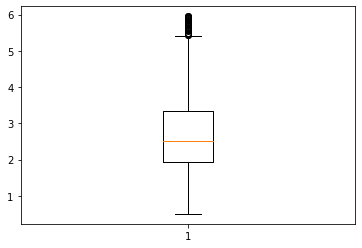

In [4]:
#Find the outliers 
box = plt.boxplot(file_data.len)

In [5]:
#Find the relative maximum -- 16s is an unusual breath cycles.
#Choose a relative maximum length of breathcycle as 6s as most of the data falls undes 6s 
rel_max = [item.get_ydata()[1] for item in box['whiskers']][1]
rel_max = np.floor(rel_max)
rel_max

5.0

In [6]:
#Set maxpad length as 94 <--(Sampling rate*6s)/256(hop length)
def Short_features(df):
    X = []
    Y = []
    for i in tqdm(range(len(df))):
        file = df.iloc[i].fname_cycle
        label = df.iloc[i].crack_wheez
        [Fs, x] = audioBasicIO.read_audio_file('Breath_cycles/' +file)
        F, f_names = ShortTermFeatures.feature_extraction(x, Fs, 0.256*Fs, 0.128*Fs, deltas=False)
        mean_F =[]
        for i in range(len(F)):
            mean_F.append(np.mean(F[i]))
        X.append(mean_F)
        Y.append(label)
    X, Y = np.array(X), np.array(Y)    
    return X, Y

In [7]:
[Fs, x] = audioBasicIO.read_audio_file('Breath_cycles/101_1b1_Al_sc_Meditron_0.wav')
F, f_names = ShortTermFeatures.feature_extraction(x, Fs, 0.256*Fs, 0.128*Fs, deltas=False)

In [8]:
f_names

['zcr',
 'energy',
 'energy_entropy',
 'spectral_centroid',
 'spectral_spread',
 'spectral_entropy',
 'spectral_flux',
 'spectral_rolloff',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'chroma_1',
 'chroma_2',
 'chroma_3',
 'chroma_4',
 'chroma_5',
 'chroma_6',
 'chroma_7',
 'chroma_8',
 'chroma_9',
 'chroma_10',
 'chroma_11',
 'chroma_12',
 'chroma_std']

In [9]:
#Split the dataset into train and test set
train_df, test_df = train_test_split(file_data, test_size=0.2, random_state=0)

In [10]:
train_df

,fname,start,end,crack_wheez,fname_cycle,len
3943,172_1b3_Pr_mc_AKGC417L,17.571,19.975,1,172_1b3_Pr_mc_AKGC417L_6.wav,2.404
2632,152_1b1_Al_sc_Meditron,11.279,14.507,0,152_1b1_Al_sc_Meditron_4.wav,3.228
828,120_1b1_Pr_sc_Meditron,53.735,57.214,0,120_1b1_Pr_sc_Meditron_17.wav,3.479
1371,130_2p5_Tc_mc_AKGC417L,15.978,17.937,1,130_2p5_Tc_mc_AKGC417L_8.wav,1.959
3051,158_1b3_Ar_mc_LittC2SE,12.364,15.021,1,158_1b3_Ar_mc_LittC2SE_7.wav,2.657
...,...,...,...,...,...,...
4931,188_1b1_Ar_sc_Meditron,16.421,17.607,0,188_1b1_Ar_sc_Meditron_14.wav,1.186
3264,159_1b1_Al_sc_Meditron,4.693,6.493,0,159_1b1_Al_sc_Meditron_3.wav,1.800
1653,133_3p2_Ar_mc_AKGC417L,0.851,2.197,0,133_3p2_Ar_mc_AKGC417L_0.wav,1.346
2607,151_3p2_Pl_mc_AKGC417L,10.860,14.232,1,151_3p2_Pl_mc_AKGC417L_3.wav,3.372


In [11]:
#Reset index
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [13]:
#Extract features for training data
X_, y_ = Short_features(train_df)

100%|██████████| 5390/5390 [08:38<00:00, 10.39it/s]


In [14]:
#Extract feature for testing data
X_test, y_test = Short_features(test_df)

100%|██████████| 1348/1348 [02:17<00:00,  9.79it/s]


In [15]:
#Convert labels into one hot vectors
y_tr_cat= to_categorical(y_, num_classes=4)
y_test_cat= to_categorical(y_test, num_classes=4)

In [16]:
np.save('X_tr', X_)
np.save('X_test', X_test)

np.save('y_tr', y_)
np.save('y_test', y_test)

In [ ]:
X_ = np.load('X_tr.npy')
X_test = np.load('X_test.npy')

y_ = np.load('y_tr.npy')
y_test = np.load('y_test.npy')

In [17]:
X_train = np.reshape(X_, (X_.shape[0], X_.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],  1))

In [30]:
def SeperablaConv():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='tanh', input_shape=(34, 1)))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2)) 
    model.add(Dropout(0.25))
    model.add(SeparableConv1D(256, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2)) 
    model.add(Dropout(0.5))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(512, activation='relu'))   
    model.add(Dense(4, activation='softmax'))
    return model

In [31]:
SeperablaConv().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 30, 64)            384       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 26, 128)           41088     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 128)           0         
_________________________________________________________________
separable_conv1d_4 (Separabl (None, 9, 256)            33664     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 4, 256)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 256)           

In [36]:
model = SeperablaConv()

In [37]:
#Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [22]:
class_weight = compute_class_weight('balanced', np.unique(y_), y_)

/home/014544907/anaconda3/envs/master_project/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=[1 0 0 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [ ]:
model.fit(X_train,y_tr_cat, epochs = 150, batch_size = 64, shuffle= True,  validation_data=(X_test, y_test_cat), class_weight = class_weight, verbose = True)

                precision    recall  f1-score   support

          None       0.69      0.75      0.72       702
       Crackle       0.52      0.57      0.54       350
        Wheeze       0.52      0.34      0.41       199
Crackle_wheeze       0.44      0.32      0.37        97

      accuracy                           0.61      1348
     macro avg       0.54      0.50      0.51      1348
  weighted avg       0.60      0.61      0.60      1348



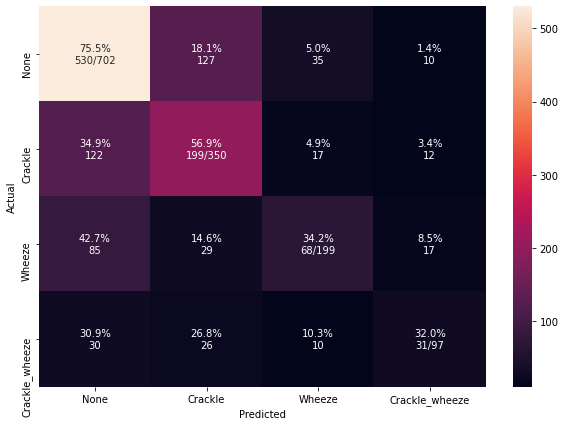

In [39]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
matrix_index = ["None", "Crackle", "Wheeze", "Crackle_wheeze"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test_cat, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')